In [1]:
import numpy as np
from numba import vectorize
import matplotlib.pyplot as plt
import torch
plt.style.use(['science','notebook'])

import sys
sys.path.insert(0, '../src/pydftlj')
from dft3dgpu import dft3d

# Author: Elvis do A. Soares
# Github: @elvissoares
# Date: 2023-04-27

/home/elvis/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available(): print(torch.cuda.get_device_properties(device))

In [3]:
@vectorize
def ljpotential(r,eps,sigma):
    return 4*eps*((sigma/r)**(12)-(sigma/r)**(6))

# Defining the fluid properties

In [19]:
# fluid properties
sigma = 1.0
epsilon = 1.0
L = 11.2*sigma
# Temperature and Density 
kT = 2.934
rhob = 0.450
# kT = 2.888
# rhob = 0.850

# Defining the functional 


In [35]:
# Test the HS functional 
Ngrid = 128
DFT = dft3d(gridsize=(Ngrid,Ngrid,Ngrid),ljmethod='MMFA')
DFT.Set_Geometry(L=L)
DFT.Set_FluidProperties(sigma=sigma,epsilon=epsilon)
DFT.Set_Temperature(kT)
DFT.Set_BulkDensity(rhob)

In [36]:
DFT.delta

array([0.0875, 0.0875, 0.0875])

In [37]:
R = np.sqrt(DFT.X**2+DFT.Y**2+DFT.Z**2+1e-16)
Vext = ljpotential(R,epsilon,sigma)
DFT.Set_External_Potential(Vext)

del R

(-5.64375, 5.556250000000046, -5.64375, 5.556250000000046)

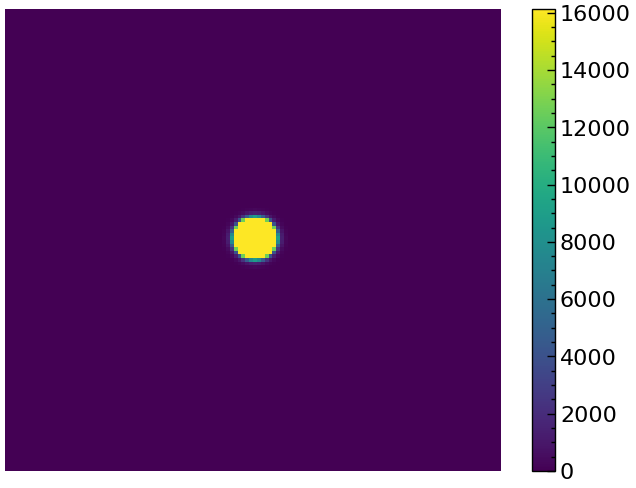

In [38]:
plt.figure(figsize=(8,6))
c=plt.pcolormesh(DFT.X[:,:,Ngrid//2],DFT.Y[:,:,Ngrid//2],DFT.Vext[:,:,Ngrid//2].cpu(), cmap='viridis')
plt.colorbar(c)
plt.axis('off')

## Setting the Initial Condition

In [39]:
DFT.Set_InitialCondition()

In [40]:
DFT.rho.min(),DFT.rho.max()

(tensor(0.), tensor(0.4500))

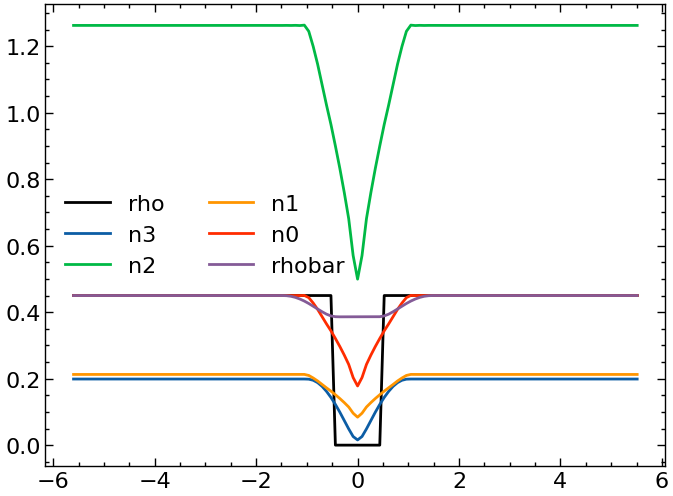

In [41]:
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.rho[:,Ngrid//2,Ngrid//2].numpy(),color='k',label='rho')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.n3[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='n3')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.n2[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='n2')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.n1[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='n1')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.n0[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='n0')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.rhobar[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='rhobar')
plt.legend(loc='best',ncols=2)

## Calculate Equilibrium

In [42]:
# DFT.Calculate_Equilibrium(alpha0=0.6,rtol=1e-1,atol=1e-2,max_iter=15,method='picard',logoutput=True)
# DFT.Calculate_Equilibrium(alpha0=0.1,dt=0.1,rtol=1e-4,atol=1e-6,method='fire',logoutput=True)
DFT.Calculate_Equilibrium(rtol=1e-4,atol=1e-6,method='rkf2(3)',logoutput=True)

0 -1195.5319 430277.4 0.5
3 -2545.9763 1350444400.0 0.05955915
4 -2550.0115 4035156.2 0.060090855
5 -2551.4177 1406250.0 0.061485346
6 -2552.1362 718505.9 0.063226506
7 -2552.5737 437500.0 0.065158606
8 -2552.867 293212.9 0.067239396
9 -2553.0752 208251.95 0.06946378
10 -2553.231 155761.72 0.071839765
11 -2553.3494 118408.2 0.074380875
12 -2553.4417 92285.16 0.0771039
13 -2553.5156 73974.61 0.08002856
14 -2553.5742 58593.75 0.08317761
15 -2553.6218 47607.42 0.08657744
16 -2553.6604 38574.22 0.09025868


/home/elvis/Google Drive/Projetos em Andamento/2-DFT in Amorphous Carbon/codes/PyDFTlj/examples/../src/pydftlj/dft3dgpu.py:181: RuntimeWarning: invalid value encountered in dphi3dnfuncWBI
  self.dphi3dn3 = torch.tensor(dphi3dnfuncWBI(self.n3.numpy()),dtype=torch.float32)


17 -2553.6912 30761.719 0.09425706
18 -2553.7173 26123.047 0.098614536
19 -2553.7378 20507.812 0.10338074
20 -2553.7544 16601.562 0.10861469
21 -2553.768 13671.875 0.11438709
22 -2553.779 10986.328 0.12078346
23 -2553.7876 8544.922 0.12790814
24 -2553.7944 6835.9375 0.13588944
25 -2553.7998 5371.0938 0.14488731
26 -2553.804 4150.3906 0.15510298
27 -2553.8074 3417.9688 0.16679347
28 -2553.81 2685.5469 0.18029149
29 -2553.8125 2441.4062 0.19603503
30 -2553.814 1464.8438 0.21461222
31 -2553.8147 732.4219 0.23682909
32 -2553.816 1220.7031 0.26381767
33 -2553.8162 244.14062 0.2972158
34 -2553.8167 488.28125 0.3394719
36 -2553.8167 0.0 0.3030878
Time to achieve equilibrium: 158.6703018419994 sec
Number of iterations: 36
error: 0.0
---- Equilibrium quantities ----
Fid = -3329.891
Fexc = 152.70654
Omega = -2553.8167
Nbulk = 632.2175999999998
Nabs = 631.6029


In [43]:
DFT.Niter

36

In [44]:
DFT.rho.min(),DFT.rho.max()

(tensor(0.), tensor(0.7290))

In [45]:
DFT.Omega

tensor(-2553.8167)

(-5.64375, 5.556250000000046, -5.64375, 5.556250000000046)

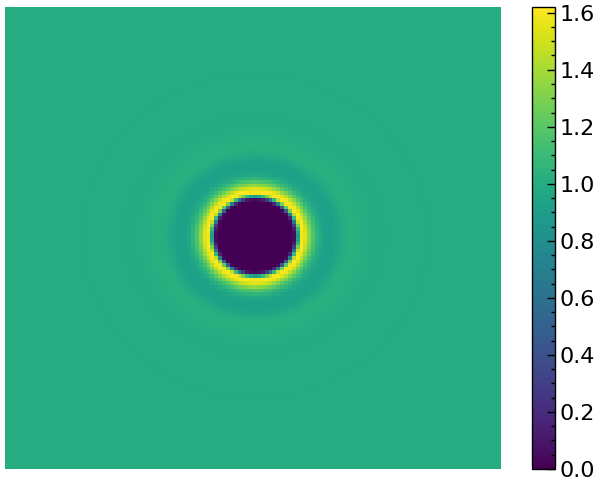

In [46]:
plt.figure(figsize=(8,6))
c=plt.pcolormesh(DFT.X[:,:,Ngrid//2],DFT.Y[:,:,Ngrid//2],DFT.rho[:,:,Ngrid//2].numpy()/rhob, cmap='viridis')
plt.colorbar(c)
plt.axis('off')

In [47]:
np.save(f'radialdistribution-3D-rhob={rhob}-kT={kT}-Ngrid={Ngrid}-ljmethod={DFT.ljmethod}.npy',(DFT.Z[Ngrid//2,Ngrid//2,:],DFT.rho[Ngrid//2,Ngrid//2,:].numpy()/rhob))

r,g = np.load(f'radialdistribution-3D-rhob={rhob}-kT={kT}-Ngrid=128-ljmethod={DFT.ljmethod}.npy')

## Plotting g(r)

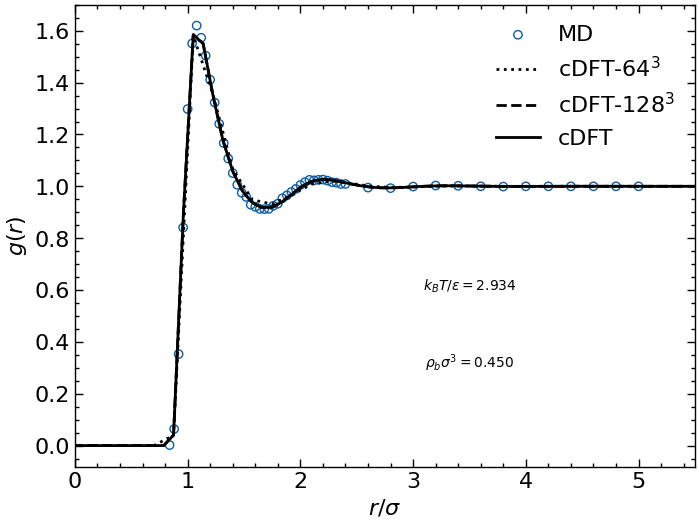

In [48]:
import pandas as pd
df = pd.read_excel('data/MC/MCdata-radialdistribution-lennardjones-Verlet1968.xls',sheet_name='rhob=0.450')
plt.scatter(df['r'],df['KT=2.934'],marker='o',edgecolors='C0',facecolors='none',label='MD')
r,g = np.load(f'radialdistribution-3D-rhob={rhob}-kT={kT}-Ngrid=64-ljmethod={DFT.ljmethod}.npy')
plt.plot(r,g,':',color='k',label=r'cDFT-64$^3$')
r,g = np.load(f'radialdistribution-3D-rhob={rhob}-kT={kT}-Ngrid=128-ljmethod={DFT.ljmethod}.npy')
plt.plot(r,g,'--',color='k',label=r'cDFT-128$^3$')
plt.plot(DFT.Z[Ngrid//2,Ngrid//2,:],DFT.rho[Ngrid//2,Ngrid//2,:].numpy()/rhob,'-',color='k',label=r'cDFT')
plt.xlim(0.0,5.5)
# plt.ylim(0,2.0)
plt.xlabel(r'$r/\sigma$')
plt.ylabel(r'$g(r)$')
plt.text(3.5,0.6,r'$k_B T/\epsilon = 2.934$',ha='center')
plt.text(3.5,0.3,r'$\rho_b \sigma^3 = 0.450$',ha='center')
plt.legend(loc='upper right',ncol=1)